In [213]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-depression-machine-learning-challenge/sample_submission.csv
/kaggle/input/predicting-depression-machine-learning-challenge/train.csv
/kaggle/input/predicting-depression-machine-learning-challenge/test.csv


In [214]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier
import xgboost as xgb

from scipy.stats import uniform
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns', None)

In [215]:
train = pd.read_csv("/kaggle/input/predicting-depression-machine-learning-challenge/train.csv")
test = pd.read_csv("/kaggle/input/predicting-depression-machine-learning-challenge/test.csv")
sample = pd.read_csv("/kaggle/input/predicting-depression-machine-learning-challenge/sample_submission.csv")

In [216]:
train.head(10)

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0
5,5,Vani,Female,59.0,Ahmedabad,Working Professional,Finanancial Analyst,NaN,2.0,NaN,NaN,5.0,5-6 hours,Healthy,MCA,No,7.0,5.0,No,0
6,6,Ritvik,Male,47.0,Thane,Working Professional,Chemist,NaN,5.0,NaN,NaN,2.0,7-8 hours,Moderate,MD,No,6.0,2.0,No,0
7,7,Rajveer,Male,38.0,Nashik,Working Professional,Teacher,NaN,3.0,NaN,NaN,4.0,7-8 hours,Unhealthy,B.Pharm,No,10.0,3.0,Yes,0
8,8,Aishwarya,Female,24.0,Bangalore,Student,NaN,2.0,NaN,5.90,5.0,NaN,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
9,9,Simran,Female,42.0,Patna,Working Professional,Electrician,NaN,4.0,NaN,NaN,1.0,5-6 hours,Healthy,ME,Yes,7.0,2.0,Yes,0


In [217]:
train.shape

(140700, 20)

In [218]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [219]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,140700.0,70349.500000,40616.735775,0.00,35174.75,70349.50,105524.25,140699.0
Age,140700.0,40.388621,12.384099,18.00,29.00,42.00,51.00,60.0
Academic Pressure,27897.0,3.142273,1.380457,1.00,2.00,3.00,4.00,5.0
Work Pressure,112782.0,2.998998,1.405771,1.00,2.00,3.00,4.00,5.0
CGPA,27898.0,7.658636,1.464466,5.03,6.29,7.77,8.92,10.0
Study Satisfaction,27897.0,2.944940,1.360197,1.00,2.00,3.00,4.00,5.0
Job Satisfaction,112790.0,2.974404,1.416078,1.00,2.00,3.00,4.00,5.0
Work/Study Hours,140700.0,6.252679,3.853615,0.00,3.00,6.00,10.00,12.0
Financial Stress,140696.0,2.988983,1.413633,1.00,2.00,3.00,4.00,5.0
Depression,140700.0,0.181713,0.385609,0.00,0.00,0.00,0.00,1.0


In [220]:
(train.describe(include = "O").T)

,count,unique,top,freq
Name,140700,422,Rohan,3178
Gender,140700,2,Male,77464
City,140700,98,Kalyan,6591
Working Professional or Student,140700,2,Working Professional,112799
Profession,104070,64,Teacher,24906
Sleep Duration,140700,36,Less than 5 hours,38784
Dietary Habits,140696,23,Moderate,49705
Degree,140698,115,Class 12,14729
Have you ever had suicidal thoughts ?,140700,2,No,71138
Family History of Mental Illness,140700,2,No,70758


In [221]:
train['Dietary Habits'].unique().tolist()

['Healthy',
 'Unhealthy',
 'Moderate',
 'Yes',
 'Pratham',
 'BSc',
 'Gender',
 '3',
 'More Healthy',
 'Less than Healthy',
 'Mihir',
 '1.0',
 'Hormonal',
 'Electrician',
 nan,
 'No Healthy',
 'Less Healthy',
 'M.Tech',
 'Vegas',
 'No',
 'Male',
 'Indoor',
 'Class 12',
 '2']

In [222]:
print(train['Dietary Habits'].value_counts(dropna=False))

Dietary Habits
Moderate             49705
Unhealthy            46227
Healthy              44741
NaN                      4
Yes                      2
No                       2
More Healthy             2
Class 12                 1
Indoor                   1
Male                     1
Vegas                    1
M.Tech                   1
Less Healthy             1
No Healthy               1
Hormonal                 1
Electrician              1
1.0                      1
Mihir                    1
Less than Healthy        1
3                        1
Gender                   1
BSc                      1
Pratham                  1
2                        1
Name: count, dtype: int64


In [223]:
# invalid_rows = train[~train['Dietary Habits'].isin(['Healthy', 'Unhealthy', 'Moderate'])]
# display(invalid_rows)

In [224]:
# train = train[train['Dietary Habits'].isin(['Healthy', 'Unhealthy', 'Moderate'])]
# display(train.head())

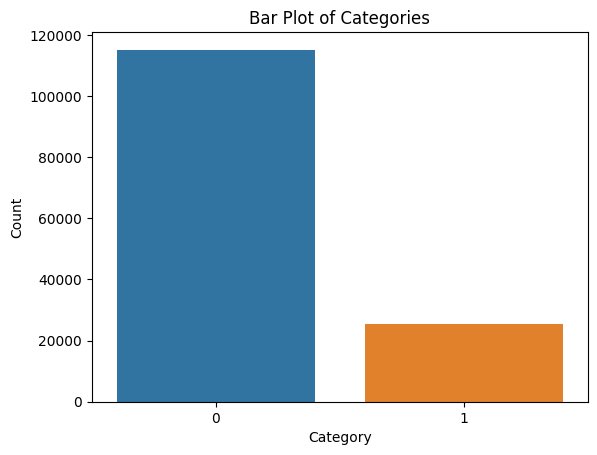

In [225]:
sns.countplot(x=train['Depression'])

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Bar Plot of Categories')
plt.show()

In [226]:
train.isna().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

In [227]:
train['Satisfaction'] = train['Job Satisfaction'].fillna(0) + train['Study Satisfaction'].fillna(0)
test['Satisfaction'] = test['Job Satisfaction'].fillna(0) + test['Study Satisfaction'].fillna(0)
train['Satisfaction'].value_counts()

Satisfaction
2.0    30622
1.0    27775
3.0    27772
4.0    27280
5.0    27234
0.0       15
6.0        1
7.0        1
Name: count, dtype: int64

In [228]:
train = train.drop(train[(train['Satisfaction'] > 5) | (train['Satisfaction'] == 0)].index)
# test = test.drop(test[(test['Satisfaction'] > 5) | (test['Satisfaction'] == 0)].index)

In [229]:
train['Pressure'] = train['Academic Pressure'].fillna(0) + train['Work Pressure'].fillna(0)
test['Pressure'] = test['Academic Pressure'].fillna(0) + test['Work Pressure'].fillna(0)
train['Pressure'].value_counts()

Pressure
3.0    29361
5.0    28728
2.0    28552
4.0    27667
1.0    26361
0.0       14
Name: count, dtype: int64

In [230]:
train['Profession'] = train['Profession'].combine_first(train['Working Professional or Student'])
test['Profession'] = test['Profession'].combine_first(test['Working Professional or Student'])

In [231]:
train = train.drop(train[train['Pressure']==0].index)
# test = test.drop(test[test['Pressure']==0].index)
train.sample(10)

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Satisfaction,Pressure
101304,101304,Rohan,Male,41.0,Delhi,Working Professional,Electrician,NaN,1.0,NaN,NaN,2.0,5-6 hours,Unhealthy,MSc,Yes,0.0,3.0,Yes,0,2.0,1.0
31044,31044,Nishant,Male,27.0,Ghaziabad,Student,Student,1.0,NaN,7.87,2.0,NaN,7-8 hours,Unhealthy,B.Com,No,0.0,1.0,Yes,0,2.0,1.0
58297,58297,Yuvraj,Male,48.0,Hyderabad,Working Professional,Data Scientist,NaN,4.0,NaN,NaN,4.0,Less than 5 hours,Unhealthy,M.Tech,No,10.0,3.0,Yes,0,4.0,4.0
125529,125529,Raunak,Male,37.0,Vasai-Virar,Working Professional,Consultant,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,BSc,No,4.0,2.0,Yes,0,5.0,3.0
137853,137853,Gagan,Male,21.0,Lucknow,Student,Student,3.0,NaN,8.91,4.0,NaN,More than 8 hours,Moderate,B.Ed,Yes,10.0,1.0,Yes,1,4.0,3.0
61532,61532,Rupak,Male,57.0,Bangalore,Working Professional,Electrician,NaN,2.0,NaN,NaN,1.0,More than 8 hours,Unhealthy,ME,No,1.0,4.0,Yes,0,1.0,2.0
139948,139948,Veda,Female,54.0,Faridabad,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,More than 8 hours,Unhealthy,M.Tech,Yes,12.0,3.0,Yes,0,1.0,5.0
109231,109231,Harsha,Male,43.0,Visakhapatnam,Working Professional,Teacher,NaN,2.0,NaN,NaN,2.0,7-8 hours,Moderate,B.Arch,No,5.0,2.0,No,0,2.0,2.0
129655,129655,Pallavi,Female,59.0,Indore,Working Professional,UX/UI Designer,NaN,3.0,NaN,NaN,3.0,More than 8 hours,Healthy,MSc,No,5.0,5.0,No,0,3.0,3.0
99773,99773,Abhinav,Male,50.0,Indore,Working Professional,Financial Analyst,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,M.Com,No,5.0,2.0,Yes,0,2.0,5.0


In [232]:
students_df = train[train['Working Professional or Student'] == 'Student']
professionals_df = train[train['Working Professional or Student'] == 'Working Professional']

In [233]:
train = train.drop(columns = ['Study Satisfaction', 'Working Professional or Student', 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'id'])
test = test.drop(columns = ['Study Satisfaction', 'Working Professional or Student', 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'id'])

In [234]:
train.isnull().sum()

Name                                          0
Gender                                        0
Age                                           0
City                                          0
Profession                                    0
CGPA                                     112779
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
Satisfaction                                  0
Pressure                                      0
dtype: int64

In [235]:
test.isnull().sum()

Name                                         0
Gender                                       0
Age                                          0
City                                         0
Profession                                   0
CGPA                                     75034
Sleep Duration                               0
Dietary Habits                               5
Degree                                       2
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             0
Family History of Mental Illness             0
Satisfaction                                 0
Pressure                                     0
dtype: int64

In [236]:
# students_df['CGPA'].isna().sum()

In [237]:
# students_df.isnull().sum()

In [238]:
# students_df = students_df.drop(columns=['Working Professional or Student', 'Profession', 'Work Pressure', 'Job Satisfaction'])

In [239]:
def plot_feature_distributions(data, target='Depression', n_cols=3, categorical_override=['Compartments']):
    color_numeric = "#fc8d62"
    color_categorical = "#66c2a5"

    features = [col for col in data.columns if col != target]
    n_rows = int(np.ceil((len(features) + 1) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
    axes = axes.flatten()
    
    sns.histplot(data=data, x=target, kde=True, ax=axes[0], color=color_numeric)
    axes[0].set_title(f"Distribution of {target}", fontsize=14, fontweight='bold')
    axes[0].set_xlabel(target, fontsize=12)
    axes[0].set_ylabel("Count", fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    
    for idx, col in enumerate(features, start=1):
        is_categorical = col in categorical_override or data[col].dtype not in ['int64', 'float64']
        
        if is_categorical:
            value_counts = data[col].value_counts()
            sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[idx], color=color_categorical)
            axes[idx].set_title(f"Distribution of {col}", fontsize=14, fontweight='bold')

            axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right', fontsize=10)

            axes[idx].set_xlim(-0.5, len(value_counts) - 0.5)
        else:
            sns.histplot(data=data, x=col, kde=True, ax=axes[idx], color=color_numeric)
            axes[idx].set_title(f"Distribution of {col}", fontsize=14, fontweight='bold')
            axes[idx].grid(True, linestyle='--', alpha=0.7)

        axes[idx].set_xlabel(col, fontsize=12)
        axes[idx].set_ylabel("Count", fontsize=12)

    for i in range(len(features) + 1, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

plot_feature_distributions(train)

In [240]:
# plot_feature_distributions(test)

In [241]:
print(train.dtypes)
print('\n\n')
print(test.dtypes)

Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Profession                                object
CGPA                                     float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
Satisfaction                             float64
Pressure                                 float64
dtype: object



Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Pro

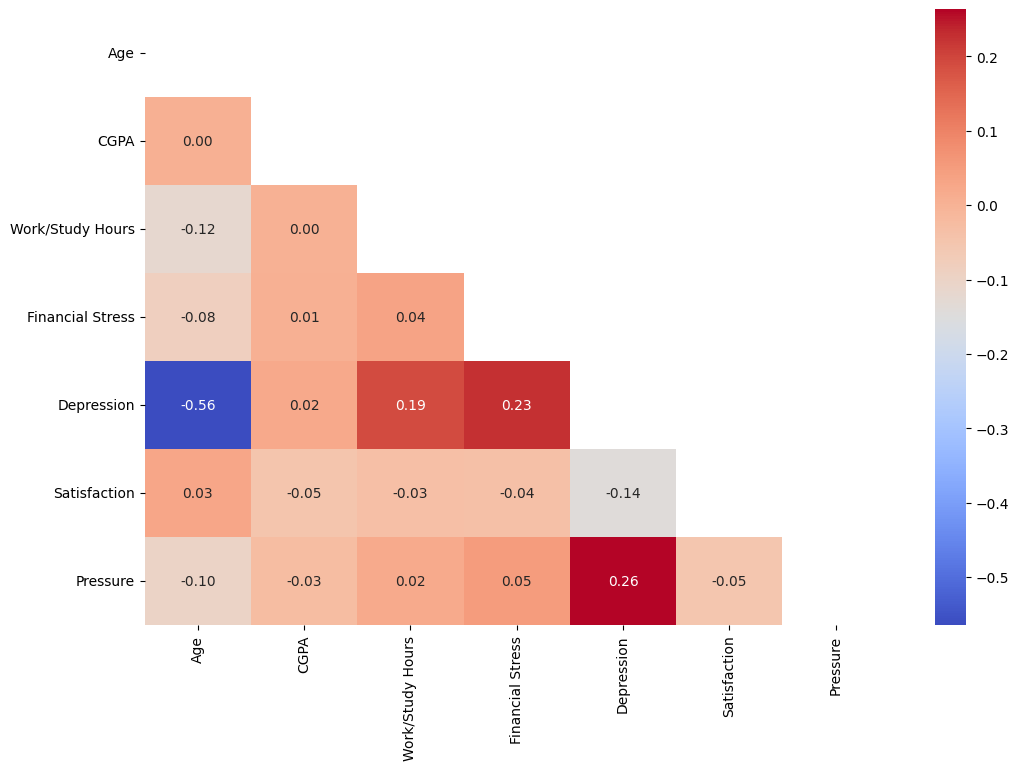

In [242]:
# corr_matrix = train.select_dtypes(include=[np.number]).corr()

# plt.figure(figsize=(12,8))
# sns.heatmap(corr_matrix, annot=True, cmap = 'viridis', fmt = ".2f")
# plt.title('Correlation Heatmap')
# plt.show()

cor_mat = train.select_dtypes(include=[np.number]).corr(method="pearson")

mask = np.triu(np.ones_like(cor_mat))

plt.figure(figsize=(12, 8))
sns.heatmap(cor_mat, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.show()

In [243]:
train.nunique()

Name                                     422
Gender                                     2
Age                                       43
City                                      98
Profession                                64
CGPA                                     331
Sleep Duration                            36
Dietary Habits                            23
Degree                                   115
Have you ever had suicidal thoughts ?      2
Work/Study Hours                          13
Financial Stress                           5
Family History of Mental Illness           2
Depression                                 2
Satisfaction                               5
Pressure                                   5
dtype: int64

In [244]:
categorical_cols = train.select_dtypes(include=['object']).columns

for col in categorical_cols:
    print(f"Unique values in '{col}':\n", train[col].unique(), "\n")

Unique values in 'Name':
 ['Aaradhya' 'Vivan' 'Yuvraj' 'Rhea' 'Vani' 'Ritvik' 'Rajveer' 'Aishwarya'
 'Simran' 'Utkarsh' 'Aahana' 'Tejas' 'Aadhya' 'Kiran' 'Aditi' 'Suhani'
 'Jiya' 'Bhavesh' 'Armaan' 'Ishaani' 'Prachi' 'Pratyush' 'Abhinav'
 'Siddhesh' 'Aditya' 'Aarav' 'Asha' 'Kashish' 'Prisha' 'Chhavi' 'Tanmay'
 'Vihaan' 'Shiv' 'Anvi' 'Darsh' 'Samar' 'Raunak' 'Mahi' 'Shaurya' 'Vidya'
 'Jai' 'Ayush' 'Ansh' 'Anand' 'Yashvi' 'Shrey' 'Ritika' 'Mihir' 'Isha'
 'Arjun' 'Rohan' 'Pratham' 'Nirvaan' 'Ishaan' 'Aarya' 'Riya' 'Aariv'
 'Raghavendra' 'Mahika' 'Abhishek' 'Harshil' 'Janvi' 'Kartikeya' 'Shivam'
 'Advait' 'Reyansh' 'Saanvi' 'Ivaan' 'Pallavi' 'Sneha' 'Ayaan' 'Aakash'
 'Raghav' 'Satyam' 'Aarush' 'Vibha' 'Rupal' 'Sanya' 'Mira' 'Rashi' 'Shlok'
 'Harsha' 'Divya' 'Pranav' 'Hrithik' 'Tushar' 'Garima' 'Zoya' 'Kian'
 'Navya' 'Lakshay' 'Kriti' 'Palak' 'Aryan' 'Parth' 'Ishan' 'Rupak'
 'Atharv' 'Aarti' 'Anirudh' 'Kabir' 'Sanjeev' 'Sanket' 'Tara' 'Gagan'
 'Anjali' 'Gaurav' 'Vikram' 'Yogesh' 'Ila' 'Rish

In [245]:
pd.options.display.max_rows=None
train['City'].value_counts(dropna=False)

City
Kalyan                6590
Patna                 5922
Vasai-Virar           5764
Kolkata               5689
Ahmedabad             5611
Meerut                5526
Ludhiana              5226
Pune                  5208
Rajkot                5207
Visakhapatnam         5175
Srinagar              5073
Mumbai                4966
Indore                4871
Agra                  4682
Surat                 4635
Varanasi              4604
Vadodara              4565
Hyderabad             4496
Kanpur                4396
Jaipur                4328
Thane                 4288
Lucknow               4280
Nagpur                4209
Bangalore             4122
Chennai               4044
Ghaziabad             3619
Delhi                 3593
Bhopal                3474
Faridabad             3266
Nashik                3142
Mihir                    7
Nandini                  4
Mahi                     3
Vidya                    3
City                     3
Pratyush                 3
Harsha                 

In [246]:
city_counts = train['City'].value_counts()
city_counts_test = test['City'].value_counts()
train['City'] = train['City'].apply(lambda x : 'other' if city_counts.get(x)<8 else x)
test['City'] = test['City'].apply(lambda x : 'other' if city_counts_test.get(x)<8 else x)
train['City'].value_counts(dropna=False)

City
Kalyan           6590
Patna            5922
Vasai-Virar      5764
Kolkata          5689
Ahmedabad        5611
Meerut           5526
Ludhiana         5226
Pune             5208
Rajkot           5207
Visakhapatnam    5175
Srinagar         5073
Mumbai           4966
Indore           4871
Agra             4682
Surat            4635
Varanasi         4604
Vadodara         4565
Hyderabad        4496
Kanpur           4396
Jaipur           4328
Thane            4288
Lucknow          4280
Nagpur           4209
Bangalore        4122
Chennai          4044
Ghaziabad        3619
Delhi            3593
Bhopal           3474
Faridabad        3266
Nashik           3142
other              98
Name: count, dtype: int64

In [247]:
prof_counts = train['Profession'].value_counts()
professions = prof_counts[prof_counts > 5].index
train = train[train['Profession'].isin(professions)]
# test = test[test['Profession'].isin(professions)]

print(train['Profession'].value_counts(dropna=False))

Profession
Student                   27863
Teacher                   24906
Working Professional       8745
Content Writer             7814
Architect                  4370
Consultant                 4229
HR Manager                 4022
Pharmacist                 3893
Doctor                     3255
Business Analyst           3161
Entrepreneur               2968
Chemist                    2967
Chef                       2862
Educational Consultant     2852
Data Scientist             2390
Researcher                 2328
Lawyer                     2212
Customer Support           2055
Marketing Manager          1976
Pilot                      1913
Travel Consultant          1860
Plumber                    1748
Sales Executive            1739
Manager                    1737
Judge                      1712
Electrician                1582
Financial Analyst          1574
Software Engineer          1510
Civil Engineer             1470
UX/UI Designer             1452
Digital Marketer           13

In [248]:
train['Sleep Duration'].value_counts(dropna=False)

Sleep Duration
Less than 5 hours    38761
7-8 hours            36950
More than 8 hours    32716
5-6 hours            32121
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
1-6 hours                4
No                       4
9-11 hours               2
10-11 hours              2
Sleep_Duration           2
Unhealthy                2
45                       2
8-9 hours                2
10-6 hours               1
9-5                      1
45-48 hours              1
3-6 hours                1
Work_Study_Hours         1
49 hours                 1
than 5 hours             1
Pune                     1
9-6 hours                1
8 hours                  1
35-36 hours              1
Indore                   1
1-3 hours                1
55-66 hours              1
Moderate                 1
40-45 hours              1
1-2 hours                1
9-5 hours                1
Name: count, 

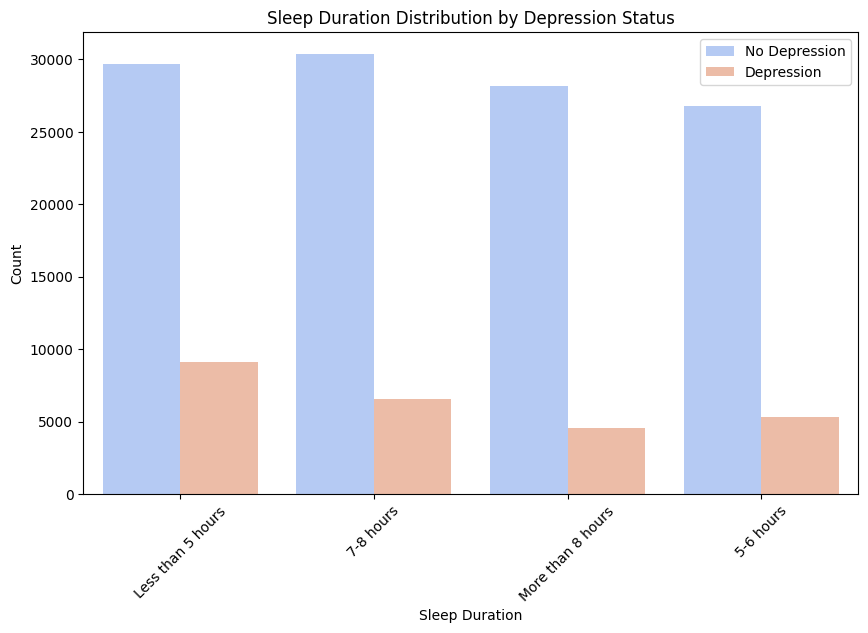

In [249]:
top = train['Sleep Duration'].value_counts().nlargest(4).index
data_sleep = train[train['Sleep Duration'].isin(top)]

plt.figure(figsize=(10, 6))
sns.countplot(
    data=data_sleep, 
    x='Sleep Duration', 
    hue='Depression', 
    order=top,
    palette='coolwarm'
)

plt.title('Sleep Duration Distribution by Depression Status')
plt.xlabel('Sleep Duration')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(labels=['No Depression', 'Depression'])
plt.show()

In [250]:
grouping = {
    '3-4 hours': 'Less than 5 hours',
    '4-5 hours': 'Less than 5 hours',
    '5-6 hours': '5-7 hours',
    '6-7 hours': '5-7 hours',
    '7-8 hours': '7-9 hours',
    '8-9 hours': '7-9 hours',
    '9-11 hours': 'More than 8 hours',
    '10-11 hours': 'More than 8 hours'
}
train['Sleep Duration'] = train['Sleep Duration'].replace(grouping)
test['Sleep Duration'] = test['Sleep Duration'].replace(grouping)

In [251]:
train.head()

,Name,Gender,Age,City,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Satisfaction,Pressure
0,Aaradhya,Female,49.0,Ludhiana,Chef,NaN,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0,2.0,5.0
1,Vivan,Male,26.0,Varanasi,Teacher,NaN,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1,3.0,4.0
2,Yuvraj,Male,33.0,Visakhapatnam,Student,8.97,5-7 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1,2.0,5.0
3,Yuvraj,Male,22.0,Mumbai,Teacher,NaN,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1,1.0,5.0
4,Rhea,Female,30.0,Kanpur,Business Analyst,NaN,5-7 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0,1.0,1.0


In [252]:
sleep_counts = train['Sleep Duration'].value_counts(dropna=False)
time = sleep_counts[sleep_counts > 5].index
train = train[train['Sleep Duration'].isin(time)]
# test = test[test['Sleep Duration'].isin(time)]

train['Sleep Duration'].value_counts()

Sleep Duration
Less than 5 hours    38780
7-9 hours            36952
More than 8 hours    32720
5-7 hours            32129
Name: count, dtype: int64

In [253]:
grouping = {
    'Yes': 'Healthy',
    'More Healthy': 'Healthy',
    'Less than Healthy': 'Moderate',
    'No Healthy': 'Unhealthy',
    'Less Healthy': 'Healthy',
    'No': 'Unhealthy'
}

train['Dietary Habits'] = train['Dietary Habits'].replace(grouping)
test['Dietary Habits'] = test['Dietary Habits'].replace(grouping)
# train['Dietary Habits'].value_counts()

diet_counts = train['Dietary Habits'].value_counts()
diet = diet_counts[diet_counts > 2].index
train = train[train['Dietary Habits'].isin(diet)]
# test = test[test['Dietary Habits'].isin(diet)]

train['Dietary Habits'].value_counts(dropna = False)

Dietary Habits
Moderate     49652
Unhealthy    46191
Healthy      44720
Name: count, dtype: int64

In [254]:
mapping = {
    "Less than 5 hours": 1,
    "5-7 hours": 2,
    "7-9 hours": 3,
    "More than 8 hours": 4
}

train["Sleep Duration"] = train["Sleep Duration"].map(mapping)
test["Sleep Duration"] = test["Sleep Duration"].map(mapping)

In [255]:
degree_counts = train['Degree'].value_counts(dropna = False)
degree_counts_test = test['Degree'].value_counts(dropna = False)
train['Degree'] = train['Degree'].apply(lambda x : 'Other' if degree_counts.get(x) <= 5 else x)
test['Degree'] = test['Degree'].apply(lambda x : 'Other' if degree_counts_test.get(x) <= 5 else x)
train['Degree'].value_counts(dropna = False)

Degree
Class 12    14707
B.Ed        11685
B.Arch       8740
B.Com        8107
B.Pharm      5851
BCA          5734
M.Ed         5663
MCA          5226
BBA          5028
BSc          5017
MSc          4874
LLM          4643
M.Pharm      4534
M.Tech       4472
B.Tech       4423
LLB          4345
BHM          4304
MBA          3811
BA           3745
ME           3627
MD           3380
MHM          3282
BE           3100
PhD          3097
M.Com        3088
MBBS         3079
MA           2886
Other         115
Name: count, dtype: int64

In [256]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140563 entries, 0 to 140699
Data columns (total 16 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140563 non-null  object 
 1   Gender                                 140563 non-null  object 
 2   Age                                    140563 non-null  float64
 3   City                                   140563 non-null  object 
 4   Profession                             140563 non-null  object 
 5   CGPA                                   27873 non-null   float64
 6   Sleep Duration                         140563 non-null  int64  
 7   Dietary Habits                         140563 non-null  object 
 8   Degree                                 140563 non-null  object 
 9   Have you ever had suicidal thoughts ?  140563 non-null  object 
 10  Work/Study Hours                       140563 non-null  float

In [257]:
# y = train['Depression']
# X = train.drop(columns = ['Depression'])

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [258]:
# def loo_encoding(full_df, train_df, val_df, col, target):
#     """
#     full_df: Original dataset containing target column
#     train_df: Training features
#     val_df: Validation features
#     col: Categorical column to encode
#     target: Target variable (Depression)
#     """
#     mean_target = full_df.groupby(col)[target].transform('mean')  # Compute mean per category
#     count_target = full_df.groupby(col)[target].transform('count')

#     train_encoded = (full_df[target] - mean_target) / (count_target - 1)  # Apply LOO formula
#     global_mean = full_df[target].mean()  # Global mean for unseen categories

#     val_encoded = val_df[col].map(full_df.groupby(col)[target].mean()).fillna(global_mean)

#     return train_encoded.loc[train_df.index], val_encoded  # Ensure correct indexing

# cols = ["City", "Profession", "Degree"]
# for col in cols:
#     X_train[f"{col}_encoded"], X_valid[f"{col}_encoded"] = loo_encoding(train, X_train, X_valid, col, "Depression")

In [259]:
train.sample(10)

,Name,Gender,Age,City,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Satisfaction,Pressure
98984,Raghavendra,Male,46.0,Nagpur,Consultant,NaN,3,Moderate,B.Tech,No,3.0,4.0,Yes,0,1.0,1.0
17243,Tara,Female,24.0,Ahmedabad,Student,5.75,1,Unhealthy,B.Tech,Yes,8.0,4.0,No,1,4.0,4.0
26099,Simran,Female,60.0,Patna,Researcher,NaN,4,Healthy,BSc,Yes,0.0,5.0,Yes,0,5.0,2.0
40232,Nandini,Female,40.0,Kanpur,Finanancial Analyst,NaN,3,Moderate,BSc,No,5.0,3.0,No,0,4.0,2.0
101125,Rishi,Male,49.0,Kanpur,Pharmacist,NaN,3,Healthy,M.Pharm,No,2.0,2.0,No,0,5.0,4.0
83516,Karishma,Female,47.0,Faridabad,Finanancial Analyst,NaN,1,Unhealthy,BSc,No,1.0,4.0,Yes,0,3.0,3.0
113858,Samar,Male,43.0,Rajkot,Architect,NaN,3,Unhealthy,BSc,Yes,6.0,5.0,No,0,3.0,3.0
85092,Kavya,Female,53.0,Faridabad,Entrepreneur,NaN,2,Healthy,BSc,No,2.0,3.0,Yes,0,5.0,3.0
17025,Nikita,Female,29.0,Ludhiana,Student,5.46,4,Unhealthy,LLB,Yes,12.0,2.0,Yes,1,1.0,3.0
52256,Abhinav,Male,39.0,Indore,Chemist,NaN,3,Unhealthy,M.Pharm,Yes,6.0,2.0,No,0,1.0,5.0


In [260]:
# loo_mappings = {}
# ivs = {}

# for col in cat:
#     print(f"Applying LOO encoding on {col}...")
#     loo_mapping = loo_encoding(train, col, 'Depression')
#     loo_mappings[col] = loo_mapping
#     ivs[col] = None
# print("LOO Encoding applied to categorical features.")

In [261]:
train['Gender'].value_counts()

Gender
Male      77386
Female    63177
Name: count, dtype: int64

In [262]:
dietary_mapping = {
    "Unhealthy": 2,
    "Moderate": 1,
    "Healthy": 0
}

train["Dietary_Habits_Encoded"] = train["Dietary Habits"].map(dietary_mapping)
test["Dietary_Habits_Encoded"] = test["Dietary Habits"].map(dietary_mapping)

train = pd.get_dummies(train, columns=["Gender"], prefix="Gender", drop_first=True)
test = pd.get_dummies(test, columns=["Gender"], prefix="Gender", drop_first=True)

le = LabelEncoder()
train["Suicidal_Thoughts_Encoded"] = le.fit_transform(train["Have you ever had suicidal thoughts ?"])
train['Mental_encoded'] = le.fit_transform(train['Family History of Mental Illness'])

test["Suicidal_Thoughts_Encoded"] = le.fit_transform(test["Have you ever had suicidal thoughts ?"])
test['Mental_encoded'] = le.fit_transform(test['Family History of Mental Illness'])

In [263]:
cols = ["City", "Profession", "Degree"]
for col in cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])

In [264]:
pd.reset_option('display.max_rows')
train['Gender_Male'] = train['Gender_Male'].astype(int)
test['Gender_Male'] = test['Gender_Male'].astype(int)

In [265]:
train['CGPA'] = train['CGPA'].fillna(-1)
test['CGPA'] = test['CGPA'].fillna(-1)

In [266]:
y = train['Depression']
X = train.drop(columns = ['Depression'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [267]:
train = train.drop(columns = ['Profession', 'City', 'Dietary Habits', 'Degree', 'Name', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'])
test = test.drop(columns = ['Profession', 'City', 'Dietary Habits', 'Degree', 'Name', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'])

In [268]:
# def loo_encoding(full_df, train_df, val_df, col, target):
#     """
#     full_df: Original dataset containing target column
#     train_df: Training features
#     val_df: Validation features
#     col: Categorical column to encode
#     target: Target variable (Depression)
#     """
#     mean_target = full_df.groupby(col)[target].transform('mean')  # Compute mean per category
#     count_target = full_df.groupby(col)[target].transform('count')

#     train_encoded = (full_df[target] - mean_target) / (count_target - 1)  # Apply LOO formula
#     global_mean = full_df[target].mean()  # Global mean for unseen categories

#     val_encoded = val_df[col].map(full_df.groupby(col)[target].mean()).fillna(global_mean)

#     return train_encoded.loc[train_df.index], val_encoded  # Ensure correct indexing

# cols = ["City", "Profession", "Degree"]
# for col in cols:
#     X_train[f"{col}_encoded"], X_valid[f"{col}_encoded"] = loo_encoding(train, X_train, X_valid, col, "Depression")

In [269]:
X_train = X_train.drop(columns = ['Profession', 'City', 'Dietary Habits', 'Degree', 'Name', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'])
X_valid = X_valid.drop(columns = ['Profession', 'City', 'Dietary Habits', 'Degree', 'Name', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'])

In [270]:
# train.info()

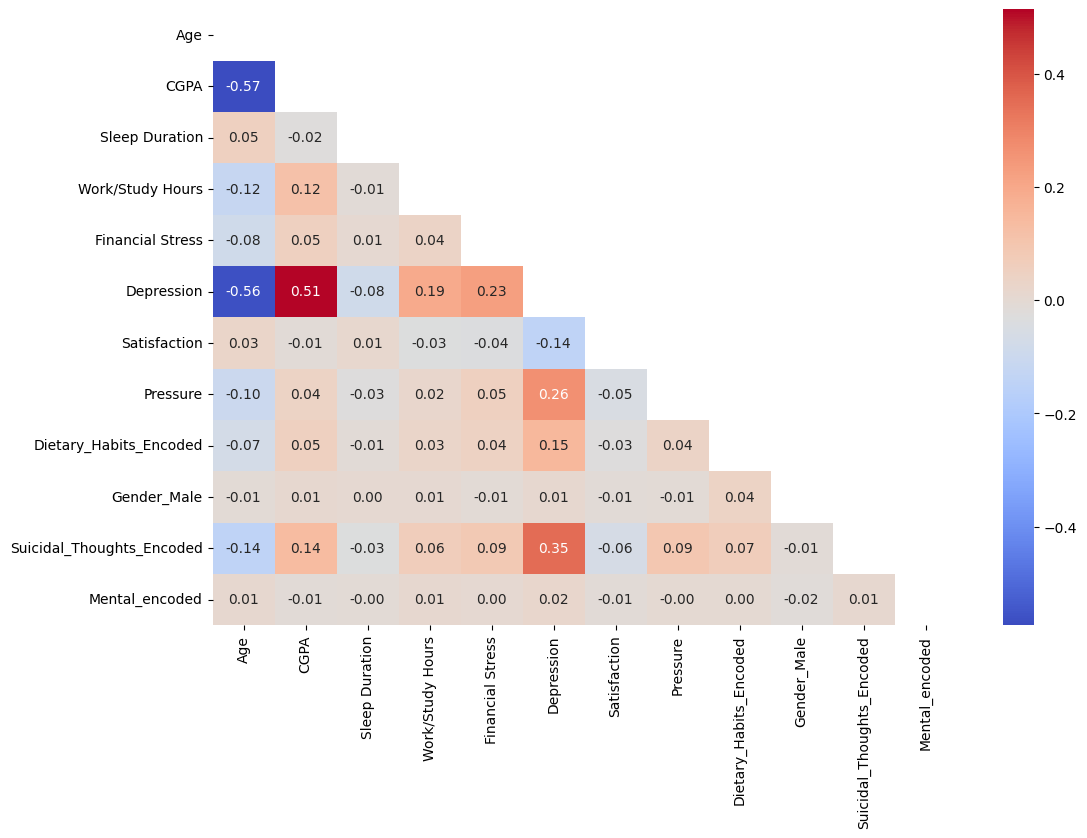

In [271]:
cor_mat = train.select_dtypes(include=[np.number]).corr(method="pearson")

mask = np.triu(np.ones_like(cor_mat))

plt.figure(figsize=(12, 8))
sns.heatmap(cor_mat, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.show()

In [272]:
# y = train['Depression']
# X = train.drop(columns = ['Depression'])

In [273]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [274]:
# assert 'Depression' not in X_train.columns, "Target variable is in features!"
# assert 'Depression' not in X_valid.columns, "Target variable is in features!"

In [275]:
import optuna
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'iterations': trial.suggest_int('iterations', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.8, 1.0),
        'random_state': 57,
        'silent': True
    }

   
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50, verbose=False)
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-02-28 04:30:59,504] A new study created in memory with name: no-name-ce66289f-3ae3-461f-85fe-a68d9d32b75c
[I 2025-02-28 04:31:01,054] Trial 0 finished with value: 0.9376445061003806 and parameters: {'learning_rate': 0.051694380056071784, 'depth': 5, 'l2_leaf_reg': 1.6017149544289782, 'iterations': 153, 'subsample': 0.9025854898281029, 'colsample_bylevel': 0.8069979208524054}. Best is trial 0 with value: 0.9376445061003806.
[I 2025-02-28 04:31:04,177] Trial 1 finished with value: 0.93917404759364 and parameters: {'learning_rate': 0.05257137560806609, 'depth': 9, 'l2_leaf_reg': 8.498950486871813, 'iterations': 158, 'subsample': 0.9874429759020422, 'colsample_bylevel': 0.9832495096430469}. Best is trial 1 with value: 0.93917404759364.
[I 2025-02-28 04:31:05,607] Trial 2 finished with value: 0.9378935012271903 and parameters: {'learning_rate': 0.04860098249115991, 'depth': 6, 'l2_leaf_reg': 5.267038681258579, 'iterations': 135, 'subsample': 0.8078789250024069, 'colsample_bylevel': 

Best Parameters: {'learning_rate': 0.03418390755373323, 'depth': 9, 'l2_leaf_reg': 6.545416966729144, 'iterations': 200, 'subsample': 0.8652977391330565, 'colsample_bylevel': 0.9091371813036032}
Best Score: 0.9392451890584427


In [276]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),  # L2 regularization (previously l2_leaf_reg)
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'random_state': 57,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)
    
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-02-28 04:35:53,363] A new study created in memory with name: no-name-de26af55-36fd-47de-b444-22b61e3bef27
[I 2025-02-28 04:35:57,944] Trial 0 finished with value: 0.9375377939031765 and parameters: {'learning_rate': 0.015006265005723407, 'max_depth': 7, 'reg_lambda': 9.015692660883314, 'n_estimators': 228, 'subsample': 0.8527690225547166, 'colsample_bytree': 0.9598101498462475}. Best is trial 0 with value: 0.9375377939031765.
[I 2025-02-28 04:36:03,432] Trial 1 finished with value: 0.9368975207199516 and parameters: {'learning_rate': 0.02383081713943552, 'max_depth': 10, 'reg_lambda': 3.6158115948554492, 'n_estimators': 441, 'subsample': 0.8123119212283467, 'colsample_bytree': 0.9158492441920101}. Best is trial 0 with value: 0.9375377939031765.
[I 2025-02-28 04:36:09,093] Trial 2 finished with value: 0.9369686621847544 and parameters: {'learning_rate': 0.011135781403116454, 'max_depth': 10, 'reg_lambda': 3.3229092651716288, 'n_estimators': 318, 'subsample': 0.9752773876053217, 

Best Parameters: {'learning_rate': 0.038545519327706175, 'max_depth': 6, 'reg_lambda': 9.874633867690537, 'n_estimators': 156, 'subsample': 0.9372816501474572, 'colsample_bytree': 0.8753195696111811}
Best Score: 0.9393163305232455


In [277]:
model = CatBoostClassifier(learning_rate = 0.022924706111027177, depth = 8, l2_leaf_reg = 7.823432059163415, iterations = 490, subsample = 0.8461945714443875, colsample_bylevel = 0.8774686028767211)
model.fit(X_train, y_train)

0:	learn: 0.6515809	total: 21ms	remaining: 10.3s
1:	learn: 0.6128622	total: 41.4ms	remaining: 10.1s
2:	learn: 0.5776560	total: 61.9ms	remaining: 10s
3:	learn: 0.5455009	total: 78.6ms	remaining: 9.55s
4:	learn: 0.5154893	total: 101ms	remaining: 9.8s
5:	learn: 0.4874587	total: 125ms	remaining: 10.1s
6:	learn: 0.4628476	total: 146ms	remaining: 10.1s
7:	learn: 0.4403988	total: 167ms	remaining: 10.1s
8:	learn: 0.4194622	total: 188ms	remaining: 10.1s
9:	learn: 0.4004638	total: 212ms	remaining: 10.2s
10:	learn: 0.3833306	total: 236ms	remaining: 10.3s
11:	learn: 0.3666742	total: 258ms	remaining: 10.3s
12:	learn: 0.3516283	total: 281ms	remaining: 10.3s
13:	learn: 0.3378786	total: 303ms	remaining: 10.3s
14:	learn: 0.3256390	total: 326ms	remaining: 10.3s
15:	learn: 0.3142841	total: 350ms	remaining: 10.4s
16:	learn: 0.3040071	total: 372ms	remaining: 10.4s
17:	learn: 0.2946418	total: 394ms	remaining: 10.3s
18:	learn: 0.2864328	total: 416ms	remaining: 10.3s
19:	learn: 0.2783870	total: 439ms	remainin

In [278]:
y_pred = model.predict(X_valid)

accuracy_score(y_valid,y_pred)

0.9390317646640345

In [279]:
model = xgb.XGBClassifier(learning_rate = 0.05303367144808915, max_depth = 4, reg_lambda = 2.429164240405971, n_estimators = 222, subsample = 0.863761026299456, colsample_bytree = 0.8964400992906235)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8964400992906235, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05303367144808915,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=222, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [280]:
y_pred = model.predict(X_valid)

accuracy_score(y_valid,y_pred)

0.93917404759364

In [281]:
output = model.predict(test)

In [283]:
sample['Depression'] = output
sample.to_csv("submission.csv", index = False)
sample

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1
